In [ ]:
from google.colab import drive # Mount the google drive for data loading
drive.mount('/content/drive')

Mounted at /content/drive


# Import some related dependencies
1.   Numpy: a package for array transformation
2.   Scipy: a package for loading data with (.mat) format
3.   Matplotlib: a package for data visualization
4.   Random: a package for randomly select samples
5.   Skearn: a package including many machine learning approaches
6.   Tensorflow: a package for neural networks modeling
7.   Keras: a package for neural networks modeling which is established on Tensorflow

In [1]:
import numpy as np #helps for array operation
import scipy.io as sio #helps to read the data
import matplotlib.pyplot as plt #helps with graphical plots
import random #helps choose random samples
from sklearn.preprocessing import OneHotEncoder #helps for label one-hot encoding
import tensorflow as tf #helps for ANN model construction
import keras #helps for ANN model construction
from keras.datasets import cifar10 #helps for loading cifar10 dataset

# Test the GPU

In [ ]:
device_name = tf.test.gpu_device_name()  # Current GPU name 
if device_name != '/device:GPU:0':       # Test if the GPU exists
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name)) 

Found GPU at: /device:GPU:0


# Visualizaiton of raw images

In [7]:
(trainX, trainY), (_, _) = cifar10.load_data() # Download the Cifar10 data online. Only the training dataset will be used for GAN training.

In [8]:
print (trainX.shape)
print (trainY.shape)

(50000, 32, 32, 3)
(50000, 1)


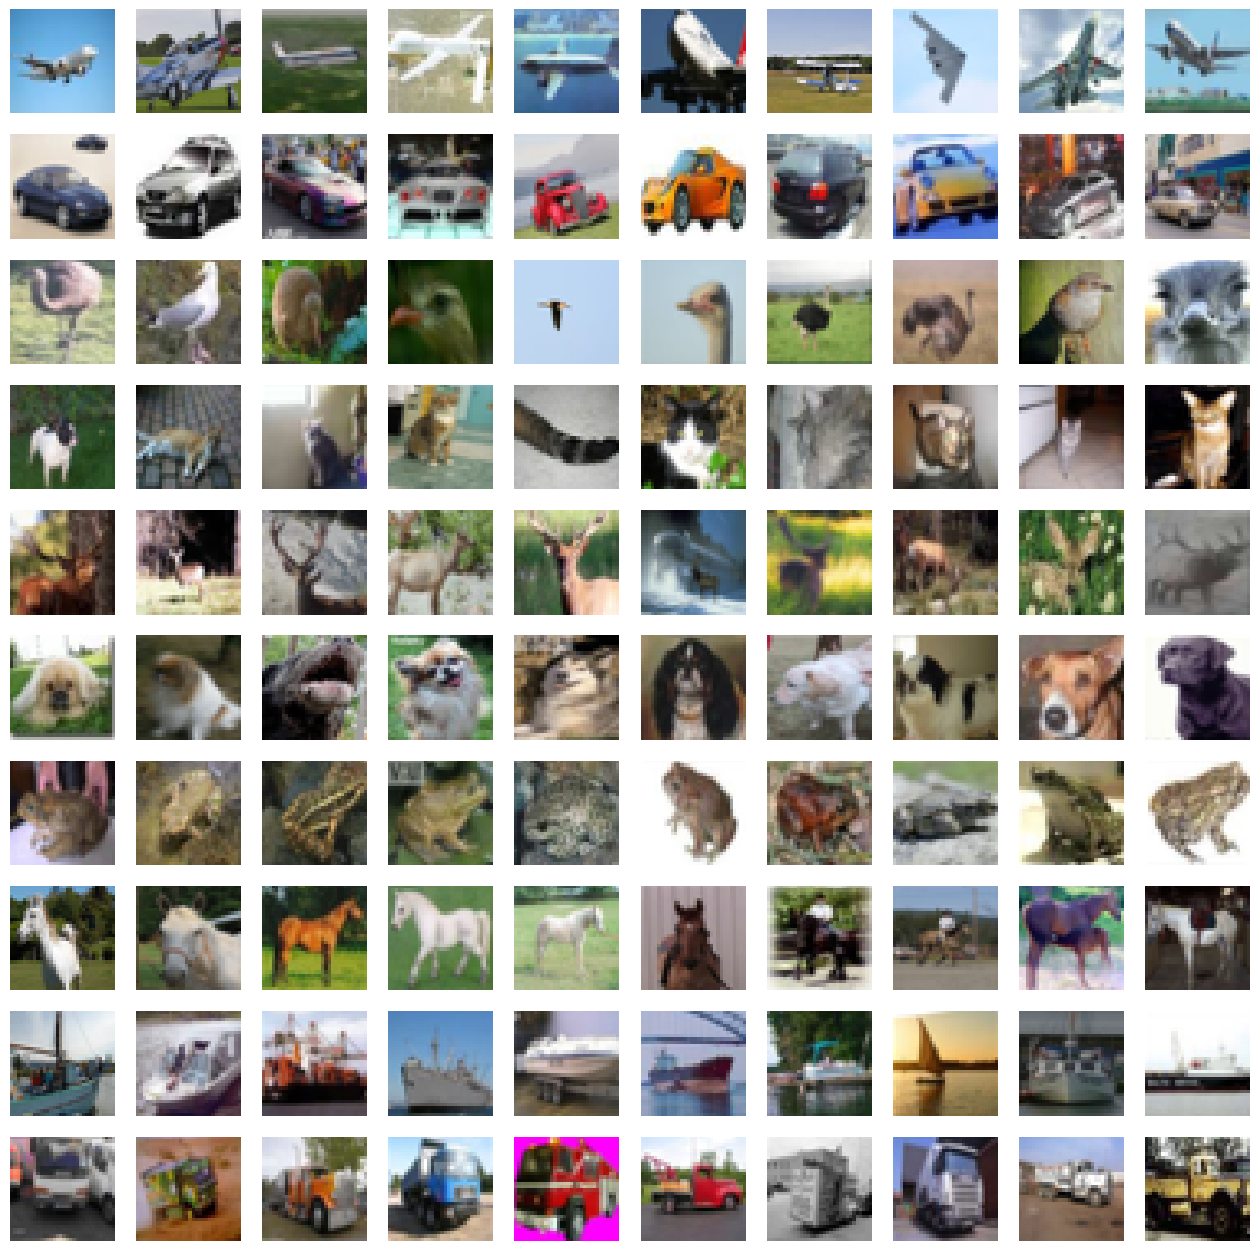

In [9]:
ix = []
for i in range(10):   
  ix = ix + random.sample(list(np.where(trainY==i)[0]), 10)                   # Randomly choose 10 indices from each class, total 100 indices
X = trainX[ix]		                                                            # Choose 10*10 samples as the selected index
plt.figure(figsize=(16,16))                                                   # Set the whole figure size 
for i in range(10 * 10):           	                                          # Plot images
  plt.subplot(10, 10, 1 + i)                                                  # Define subplot
  plt.axis('off')									                                            # Turn off axis, only show the generated images
  plt.imshow(X[i]/255)                                                        # Show the images after converting the image to [0,1]
plt.show()

#Define a discriminator
The discriminator is used to try to discriminate the generated samples and real samples.

In [10]:
def define_discriminator(in_shape=(32,32,3)):   																	# A function with one parameter of input shape 
	in_label = keras.layers.Input(shape=(1,))                                       # Shape of label 
	li = keras.layers.Embedding(10, 50)(in_label)																		# Embedding for categorical input
	li = keras.layers.Dense(32 * 32 *3)(li)																					# Transformation to a 1-D image shape 
	li = keras.layers.Reshape((32, 32, 3))(li)																			# Reshape to an 3-D image shape 
	in_image = keras.layers.Input(shape=in_shape)																		# Image input
	merge = keras.layers.Concatenate()([in_image, li])															# Merge label and input
	fe = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)     	# Convolutional layer with 128 filters. Kernel size is (3,3), stride is (2,2)
	fe = keras.layers.LeakyReLU(alpha=0.2)(fe)																			# Leaky ReLU activation function with a slope of 0.2
	fe = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)					# Convolutional layer with 128 filters. Kernel size is (3,3), stride is (2,2)
	fe = keras.layers.LeakyReLU(alpha=0.2)(fe)																			# Leaky ReLU activation function with a slope of 0.2
	fe = keras.layers.Flatten()(fe)																									# Reshape the previous output to a 1-dimension vector
	fe = keras.layers.Dropout(0.4)(fe)																							# Alleviate overfitting with a dropout layer 
	out_layer = keras.layers.Dense(1, activation='sigmoid')(fe)											# Output layer with activation function of Sigmoid (Output is in (0,1))
	model = keras.models.Model([in_image, in_label], out_layer)                     # Define model, image and label are taken as input
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)														# Set the learning rate of Adam optimizer
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])  # Compile the model with the optimizer, a loss of binary crossentropy, and an accuracy metric
	model.summary()																																	# Summary the discriminator
	return model 

#Define a generator
The generator is used to generate fake samples

In [11]:
def define_generator(latent_dim):                                                   # A function with one parameter of input dimension 
	in_label = keras.layers.Input(shape=(1,))																					# Shape of label 
	li = keras.layers.Embedding(10, 50)(in_label)																			# Embedding for categorical input
	li = keras.layers.Dense(8 * 8 * 3)(li)																						# Mapping data to a high-dimension space
	li = keras.layers.Reshape((8, 8, 3))(li)																					# Reshape data to a 3-D format
	in_lat = keras.layers.Input(shape=(latent_dim,))																	# Shape of input noise														
	gen = keras.layers.Dense(128 * 8 * 8)(in_lat)																			# Mapping input to a high dimension space
	gen = keras.layers.LeakyReLU(alpha=0.2)(gen)																			# Leaky ReLU activation function with a slope of 0.2
	gen = keras.layers.Reshape((8, 8, 128))(gen)																			# Reshape data to a 3-D format
	merge = keras.layers.Concatenate()([gen, li])																			# Merge image and label
	gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) # Transposed convolutional layer with 128 filters. Kernel size is (4,4), stride is (2,2)
	gen = keras.layers.LeakyReLU(alpha=0.2)(gen)																			# Leaky ReLU activation function with a slope of 0.2
	gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)# Transposed convolutional layer with 128 filters. Kernel size is (4,4), stride is (2,2)
	gen = keras.layers.LeakyReLU(alpha=0.2)(gen)																			# Leaky ReLU activation function with a slope of 0.2
	out_layer = keras.layers.Conv2D(3, (3,3), strides=(1,1),activation='tanh', padding='same')(gen) # Convolutional layer with 3 filters. Kernel size is (3,3), stride is (1,1), activation function is tanh (-1,1). The final output shape is 32x32x3, which is an CIFAR10 image.
	model = keras.models.Model([in_lat, in_label], out_layer)													# Define model
	model.summary()																																		# Summary the generator
	return model

#Define the GAN model based on discriminator and generator
The weights in discriminator are fixed, and GAN model only updates the weights in generator.

In [12]:
def define_gan(g_model, d_model):												   							# A function with two parameters: discriminator model and generator model 
	d_model.trainable = False																							# Make weights in the discriminator not trainable
	gen_noise, gen_label = g_model.input																	# Get input noise and label from generator model
	gen_output = g_model.output																						# Get image output from the generator model
	gan_output = d_model([gen_output, gen_label])													# Connect image output and label input from generator as inputs to discriminator
	model = keras.models.Model([gen_noise, gen_label], gan_output)				# Define gan model as taking input noise and label, and outputting a real/fake
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)									# Set the learning rate of Adam optimizer
	model.compile(loss='binary_crossentropy', optimizer=opt)							# Compile the model with the optimizer, a loss of binary crossentropy, and an accuracy metric
	model.summary()																												# Summary the GAN model
	return model

# Load the real images

1.   Import the Cifar10.mat data
2.   Sample one sample every ten samples
3.   Convert data from unsigned ints to floats
4.   Normalize the data [0, 255] to an interval of [-1, 1]

In [13]:
def load_real_samples():                                                              		# Data and labels of real samples, take one sample every 10 samples
	X, Y = trainX[::10], trainY[::10]																												
	X = X.astype('float32')                                                        					# Convert data from unsigned ints to floats
	X = (X - 127.5) / 127.5                               																	# Scale data from [0,255] to [-1,1]
	return [X, Y]

# Select real images and define labels

In [14]:
def generate_real_samples(dataset, n_samples):                  	   # A function with two parameters: dataset and the number of samples in a batch
	images, labels = dataset	
	ix = np.random.randint(0, images.shape[0], n_samples)				 		   # Choose n_samples random instances
	X, Y = images[ix], labels[ix]																								
	y = np.ones((n_samples, 1)) 																			 # Define the labels of real images using 1
	return [X,Y], y

# Generate dataset for the generator

In [15]:
def generate_latent_points(latent_dim, n_samples):    # A function with two parameters: input dimension and the number of generated samples in a batch
	x_input = np.random.randn(latent_dim * n_samples) 	# Generate random noise vector with a length of latent_dim * n_samples
	x_input = x_input.reshape(n_samples, latent_dim)    # Reshape data into a batch of inputs for the generator
	labels = np.random.randint(0, 10, n_samples)        # Generate n_samples integer labels in the interval [0, 10]
	return [x_input, labels]

# Generate fake samples using the generator

In [16]:
def generate_fake_samples(g_model, latent_dim, n_samples):           							# A function with three parameters: generator model, input dimension and the number of generated samples in a batch
	x_input, labels_input = generate_latent_points(latent_dim, n_samples)           # Generate input and its label for the generator
	X = g_model.predict([x_input, labels_input])																	 	# Predict outputs, i.e., generate fake samples 
	y = np.zeros((n_samples, 1))                         														# Define the labels of fake images using 0
	return [X, labels_input], y

# Display the generated images

In [17]:
def plot_generate(examples, n = 7): # A function with three parameters: generated images, the number of images n^2 once displayed. Default n is 7, you can change it.
	plt.figure(figsize=(12,12))       # Set the whole figure size 
	examples = (examples + 1) / 2.0  	# Scale generated images from [-1,1] to [0,1]
	for i in range(n * n):           	# Plot images
		plt.subplot(n, n, 1 + i)        # Define subplot
		plt.axis('off')									# Turn off axis, only show the generated images
		plt.imshow(examples[i])         # Show the images
	plt.show()
	plt.close()

# Train the generator and discriminator


1.   Train discriminator using a half batch of real images 
2.   Train discriminator using a half batch of fake images 
3.   Generate a batch of fake samples and define their labels as real images (i.e., [0, 1])
4.   Train generator using a batch of fake images



In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=128): 								# Define the training model, n_epochs = 500, batch size = 128.
	bat_per_epo = int(dataset[0].shape[0] / n_batch)                                         							# Calculate the number of batches in this cifar dataset
	half_batch = int(n_batch / 2)																																					# Compute a half of batch
	for i in range(n_epochs): 																																						# A loop of model training for n_epochs
		for j in range(bat_per_epo):																																				# A loop of model training for bat_per_epo times in each epoch
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)												# Get randomly selected 'real' images of half batch
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)																# Train discriminator model weights using real images
			[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)						# Generate 'fake' images of half batch						
			d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)														  	# Train discriminator model weights using fake images
			[X_gan, labels_gan] = generate_latent_points(latent_dim, n_batch)																	# Prepare input and label of a batch for the generator
			y_gan = np.ones((n_batch, 1))						  																												# Define their labels as real images (i.e., 1) to generate more realistic images
			g_loss = gan_model.train_on_batch([X_gan, labels_gan], y_gan)																			# Train generator model weights using fake images												
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))  # Summarize loss on this batch
		if (i+1) % 10 == 0:																																									# Evaluate the model performance and visualise the generated images every 10 epochs
			plot_generate(X_fake)		
			filename = 'generator_model_%d.h5' % (i+1)																												# Save the generator every 10 epochs
			g_model.save(filename)	

# Model training and visualization

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 3072)      156672      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

 dense_2 (Dense)                (None, 1, 192)       9792        ['embedding_1[0][0]']            
                                                                                                  
 reshape_2 (Reshape)            (None, 8, 8, 128)    0           ['leaky_re_lu_2[0][0]']          
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 8, 3)      0           ['dense_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8, 8, 131)    0           ['reshape_2[0][0]',              
                                                                  'reshape_1[0][0]']              
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 128)  268416     ['concatenate_1[0][0]']          
 ose)     

2023-05-17 19:00:21.614678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/sunny/opt/anaconda3/envs/AI/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 0s 72ms/step
>1, 1/39, d1=0.706, d2=0.696 g=0.690
2/2 [==============================] - 0s 70ms/step
>1, 2/39, d1=0.647, d2=0.704 g=0.683
2/2 [==============================] - 0s 70ms/step
>1, 3/39, d1=0.607, d2=0.713 g=0.673
2/2 [==============================] - 0s 70ms/step
>1, 4/39, d1=0.548, d2=0.729 g=0.662
2/2 [==============================] - 0s 73ms/step
>1, 5/39, d1=0.494, d2=0.750 g=0.647
2/2 [==============================] - 0s 69ms/step
>1, 6/39, d1=0.453, d2=0.771 g=0.632
2/2 [==============================] - 0s 69ms/step
>1, 7/39, d1=0.407, d2=0.792 g=0.626
2/2 [==============================] - 0s 70ms/step
>1, 8/39, d1=0.397, d2=0.797 g=0.634
2/2 [==============================] - 0s 69ms/step
>1, 9/39, d1=0.353, d2=0.775 g=0.663
2/2 [==============================] - 0s 70ms/step
>1, 10/39, d1=0.308, d2=0.747 g=0.703
2/2 [==============================] - 0s 72ms/step
>1, 11/39, d1=0.306, d2=0.708 g=0.740
2/2 [==============

2/2 [==============================] - 0s 70ms/step
>3, 14/39, d1=0.228, d2=0.232 g=2.133
2/2 [==============================] - 0s 69ms/step
>3, 15/39, d1=0.207, d2=0.190 g=2.304
2/2 [==============================] - 0s 70ms/step
>3, 16/39, d1=0.190, d2=0.184 g=2.575
2/2 [==============================] - 0s 70ms/step
>3, 17/39, d1=0.144, d2=0.094 g=2.880
2/2 [==============================] - 0s 69ms/step
>3, 18/39, d1=0.439, d2=0.150 g=2.281
2/2 [==============================] - 0s 70ms/step
>3, 19/39, d1=0.214, d2=0.219 g=2.710
2/2 [==============================] - 0s 70ms/step
>3, 20/39, d1=0.262, d2=0.121 g=2.830
2/2 [==============================] - 0s 70ms/step
>3, 21/39, d1=0.350, d2=0.143 g=2.624
2/2 [==============================] - 0s 70ms/step
>3, 22/39, d1=0.221, d2=0.228 g=2.843
2/2 [==============================] - 0s 70ms/step
>3, 23/39, d1=0.289, d2=0.326 g=3.005
2/2 [==============================] - 0s 70ms/step
>3, 24/39, d1=0.417, d2=0.319 g=2.445
2/2 [=====

2/2 [==============================] - 0s 69ms/step
>5, 27/39, d1=0.757, d2=0.596 g=1.249
2/2 [==============================] - 0s 69ms/step
>5, 28/39, d1=0.804, d2=0.518 g=1.266
2/2 [==============================] - 0s 70ms/step
>5, 29/39, d1=0.811, d2=0.577 g=1.262
2/2 [==============================] - 0s 70ms/step
>5, 30/39, d1=0.777, d2=0.640 g=1.253
2/2 [==============================] - 0s 70ms/step
>5, 31/39, d1=0.810, d2=0.561 g=1.215
2/2 [==============================] - 0s 72ms/step
>5, 32/39, d1=0.858, d2=0.728 g=1.185
2/2 [==============================] - 0s 71ms/step
>5, 33/39, d1=0.819, d2=0.618 g=1.186
2/2 [==============================] - 0s 70ms/step
>5, 34/39, d1=0.942, d2=0.652 g=1.134
2/2 [==============================] - 0s 71ms/step
>5, 35/39, d1=0.951, d2=0.670 g=1.131
2/2 [==============================] - 0s 71ms/step
>5, 36/39, d1=0.980, d2=0.616 g=1.087
2/2 [==============================] - 0s 70ms/step
>5, 37/39, d1=0.928, d2=0.674 g=1.155
2/2 [=====

2/2 [==============================] - 0s 70ms/step
>8, 1/39, d1=0.784, d2=0.888 g=0.954
2/2 [==============================] - 0s 69ms/step
>8, 2/39, d1=0.920, d2=0.718 g=0.999
2/2 [==============================] - 0s 70ms/step
>8, 3/39, d1=0.896, d2=0.725 g=1.022
2/2 [==============================] - 0s 70ms/step
>8, 4/39, d1=0.855, d2=0.576 g=0.998
2/2 [==============================] - 0s 70ms/step
>8, 5/39, d1=0.861, d2=0.648 g=1.058
2/2 [==============================] - 0s 70ms/step
>8, 6/39, d1=0.895, d2=0.572 g=1.086
2/2 [==============================] - 0s 70ms/step
>8, 7/39, d1=0.776, d2=0.686 g=1.084
2/2 [==============================] - 0s 69ms/step
>8, 8/39, d1=0.863, d2=0.611 g=1.113
2/2 [==============================] - 0s 70ms/step
>8, 9/39, d1=0.803, d2=0.553 g=1.106
2/2 [==============================] - 0s 68ms/step
>8, 10/39, d1=0.689, d2=0.594 g=1.252
2/2 [==============================] - 0s 83ms/step
>8, 11/39, d1=0.725, d2=0.511 g=1.216
2/2 [==============

2/2 [==============================] - 0s 69ms/step
>10, 14/39, d1=0.665, d2=0.657 g=0.936
2/2 [==============================] - 0s 68ms/step
>10, 15/39, d1=0.542, d2=0.589 g=0.929
2/2 [==============================] - 0s 69ms/step
>10, 16/39, d1=0.625, d2=0.638 g=0.954
2/2 [==============================] - 0s 71ms/step
>10, 17/39, d1=0.620, d2=0.641 g=0.963
2/2 [==============================] - 0s 68ms/step
>10, 18/39, d1=0.572, d2=0.566 g=1.005
2/2 [==============================] - 0s 68ms/step
>10, 19/39, d1=0.617, d2=0.556 g=1.005
2/2 [==============================] - 0s 69ms/step
>10, 20/39, d1=0.622, d2=0.542 g=1.030
2/2 [==============================] - 0s 72ms/step
>10, 21/39, d1=0.560, d2=0.516 g=1.085
2/2 [==============================] - 0s 78ms/step
>10, 22/39, d1=0.634, d2=0.559 g=1.134
2/2 [==============================] - 0s 69ms/step
>10, 23/39, d1=0.569, d2=0.484 g=1.173
2/2 [==============================] - 0s 74ms/step
>10, 24/39, d1=0.627, d2=0.486 g=1.245

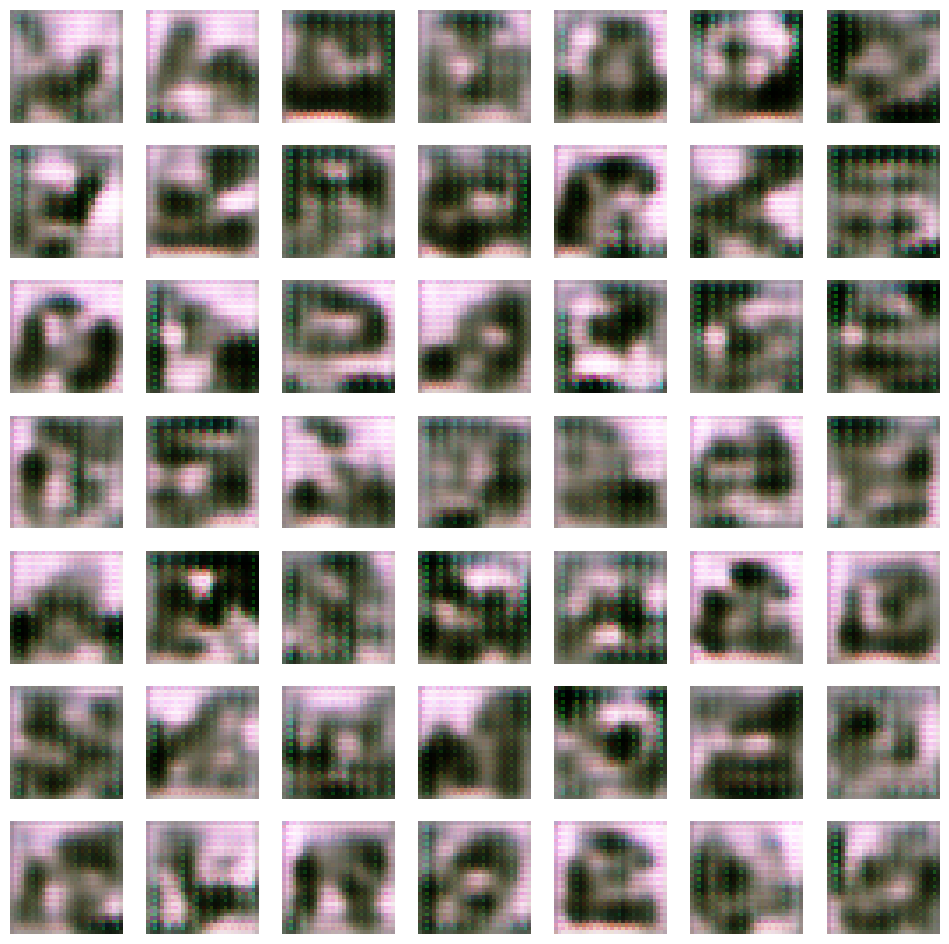

2/2 [==============================] - 0s 89ms/step
>11, 1/39, d1=0.663, d2=0.763 g=0.859
2/2 [==============================] - 0s 74ms/step
>11, 2/39, d1=0.783, d2=0.728 g=0.821
2/2 [==============================] - 0s 73ms/step
>11, 3/39, d1=0.666, d2=0.758 g=0.852
2/2 [==============================] - 0s 70ms/step
>11, 4/39, d1=0.899, d2=0.745 g=0.782
2/2 [==============================] - 0s 71ms/step
>11, 5/39, d1=0.702, d2=0.781 g=0.738
2/2 [==============================] - 0s 69ms/step
>11, 6/39, d1=0.739, d2=0.773 g=0.756
2/2 [==============================] - 0s 69ms/step
>11, 7/39, d1=0.785, d2=0.879 g=0.711
2/2 [==============================] - 0s 70ms/step
>11, 8/39, d1=0.873, d2=0.844 g=0.753
2/2 [==============================] - 0s 69ms/step
>11, 9/39, d1=0.871, d2=0.822 g=0.806
2/2 [==============================] - 0s 69ms/step
>11, 10/39, d1=0.849, d2=0.736 g=0.868
2/2 [==============================] - 0s 69ms/step
>11, 11/39, d1=0.823, d2=0.660 g=1.033
2/2 [===

2/2 [==============================] - 0s 70ms/step
>13, 11/39, d1=0.625, d2=0.648 g=0.898
2/2 [==============================] - 0s 71ms/step
>13, 12/39, d1=0.724, d2=0.686 g=0.881
2/2 [==============================] - 0s 70ms/step
>13, 13/39, d1=0.795, d2=0.690 g=0.805
2/2 [==============================] - 0s 69ms/step
>13, 14/39, d1=0.842, d2=0.717 g=0.813
2/2 [==============================] - 0s 69ms/step
>13, 15/39, d1=0.692, d2=0.735 g=0.777
2/2 [==============================] - 0s 69ms/step
>13, 16/39, d1=0.729, d2=0.772 g=0.782
2/2 [==============================] - 0s 74ms/step
>13, 17/39, d1=0.715, d2=0.738 g=0.773
2/2 [==============================] - 0s 74ms/step
>13, 18/39, d1=0.721, d2=0.784 g=0.769
2/2 [==============================] - 0s 68ms/step
>13, 19/39, d1=0.721, d2=0.691 g=0.793
2/2 [==============================] - 0s 69ms/step
>13, 20/39, d1=0.634, d2=0.672 g=0.876
2/2 [==============================] - 0s 69ms/step
>13, 21/39, d1=0.590, d2=0.726 g=0.846

2/2 [==============================] - 0s 70ms/step
>15, 23/39, d1=0.613, d2=0.701 g=0.810
2/2 [==============================] - 0s 78ms/step
>15, 24/39, d1=0.563, d2=0.686 g=0.787
2/2 [==============================] - 0s 74ms/step
>15, 25/39, d1=0.621, d2=0.708 g=0.773
2/2 [==============================] - 0s 70ms/step
>15, 26/39, d1=0.669, d2=0.712 g=0.735
2/2 [==============================] - 0s 69ms/step
>15, 27/39, d1=0.614, d2=0.761 g=0.719
2/2 [==============================] - 0s 69ms/step
>15, 28/39, d1=0.589, d2=0.764 g=0.694
2/2 [==============================] - 0s 73ms/step
>15, 29/39, d1=0.573, d2=0.830 g=0.699
2/2 [==============================] - 0s 73ms/step
>15, 30/39, d1=0.613, d2=0.803 g=0.706
2/2 [==============================] - 0s 70ms/step
>15, 31/39, d1=0.565, d2=0.832 g=0.707
2/2 [==============================] - 0s 72ms/step
>15, 32/39, d1=0.616, d2=0.769 g=0.788
2/2 [==============================] - 0s 69ms/step
>15, 33/39, d1=0.682, d2=0.694 g=0.841

KeyboardInterrupt: 

In [19]:
latent_dim = 100                                        # Give the input length of the generator model
d_model = define_discriminator()                        # Create the discriminator
g_model = define_generator(latent_dim)                  # Create the generator
gan_model = define_gan(g_model, d_model)                # Create the gan
dataset = load_real_samples()                           # Load real images
train(g_model, d_model, gan_model, dataset, latent_dim) # Train model using the parameters

# Generate some fake images using the Generator

In [15]:
model = keras.models.load_model('generator_model_490.h5')       # Load model
latent_points, labels = generate_latent_points(100, 100)        # Generate inputs
labels = np.asarray([x for _ in range(10) for x in range(10)])  # Generate labels
X  = model.predict([latent_points, labels])                     # Generate images
plot_generate(X, 10)                                            # Plot the result

OSError: No file or directory found at generator_model_490.h5